<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/MID_dos_Landsat_ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5
* Se usa Keras 2.13 y tensorflow 2.13, para esto se desinstala la actual version 3 - por corregir
* Versión con la estandarizaciíón de datos con StandardScaler
* Clasificación en tres clases (no-urbano, urbano, agua)
* Dos modelos L8 y L5

In [1]:
!pip uninstall tensorflow
!pip3 install tensorflow==2.13

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing

In [1]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [4]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/MID_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/MID_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/MID_2020_feature_L8_6b.npy')

array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/MID_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/MID_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/MID_2000_feature_L5_6b.npy')

array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/MID_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/MID_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [6]:
x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 2026, 2000)
(4052000, 6)
(6, 2026, 2000)
(4052000, 6)
(6, 2026, 2000)
(4052000, 6)
(6, 2026, 2000)
(4052000, 6)
(6, 2026, 2000)
(4052000, 6)
(6, 2026, 2000)
(4052000, 6)
(1, 2026, 2000)
(4052000, 1)
(1, 2026, 2000)
(4052000, 1)


Estandarización de datos

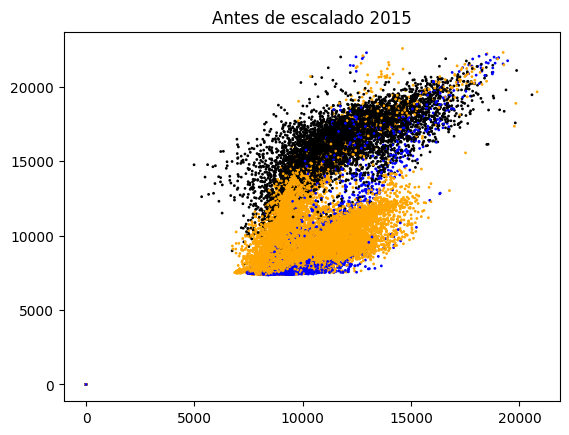

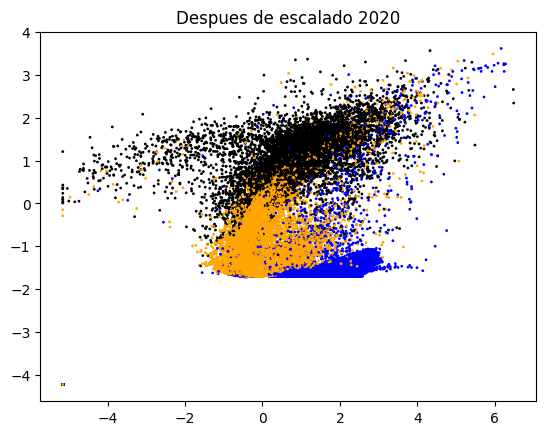

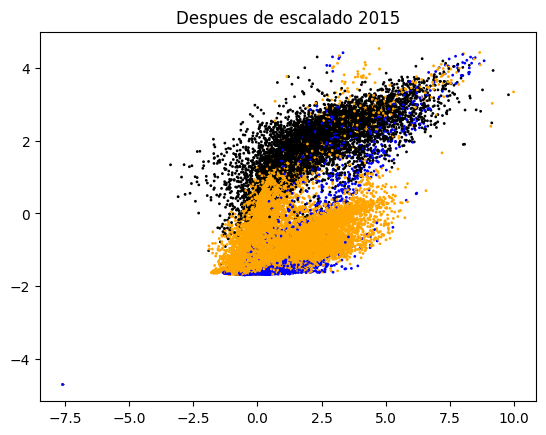

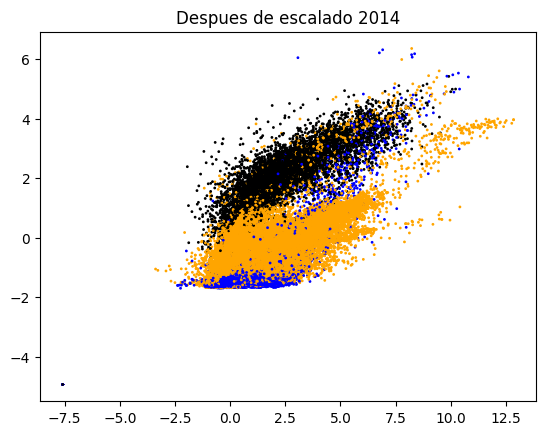

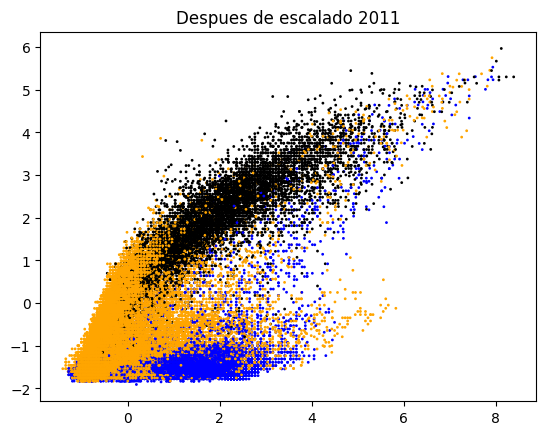

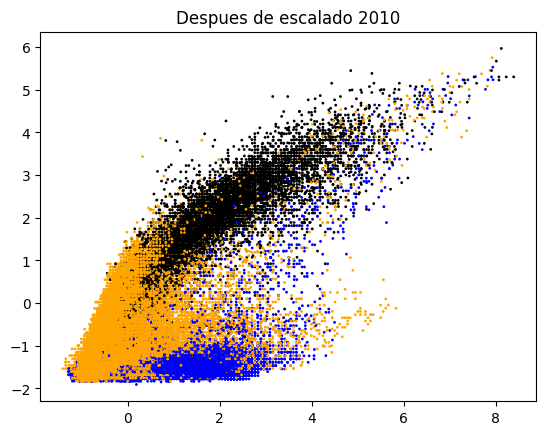

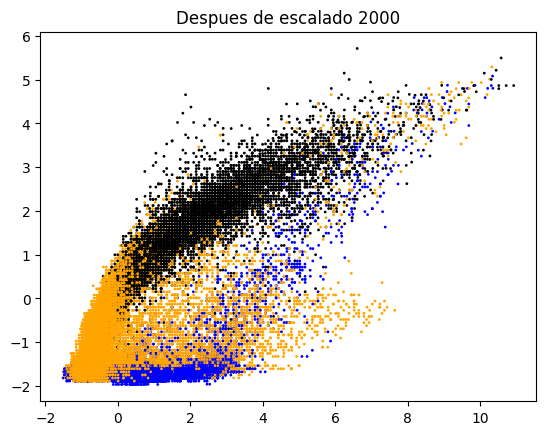

In [7]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(200000,400000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [8]:
print(x_features_2015)
print(y_labels_2015)

[[-0.06388214 -0.90823379 -1.23386354 -2.22978021 -1.96400496 -1.64403219]
 [-0.08417601 -0.9244756  -1.2386524  -2.23121192 -1.96817704 -1.65098349]
 [-0.11123451 -0.94004067 -1.25887204 -2.24266555 -1.97234912 -1.65221019]
 ...
 [ 0.34453205  0.72000767  0.88387768  1.46401848  1.39062394  1.38305401]
 [ 0.14751237  0.45472478  0.59920644  1.42307171  1.27853411  1.16143025]
 [ 0.24052595  0.51969202  0.81151266  1.36064938  1.47434364  1.35770222]]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


Subdividir datos de entrenamiento y control (2015)

In [9]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2431200, 6)
(2431200, 1)
(1620800, 6)
(1620800, 1)
[[-0.36575349 -0.41218184 -0.06059233  0.073833    0.53646049  0.46343806]
 [-0.53233236 -0.35398202 -0.33089699  0.63219792  0.18767476 -0.02642406]
 [-0.24483583 -0.141485    0.17246562  0.33182623  0.4196423   0.43645067]
 ...
 [-0.46637727 -0.42030274 -0.15264491  0.09187248  0.30087715  0.17557251]
 [-0.81052753 -0.82228754 -0.69325422  0.31579113 -0.38195296 -0.57966566]
 [ 1.18419102  1.43464732 -0.02866659 -2.18052956 -1.92562184 -1.5863773 ]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
(2431200, 1, 6) (1620800, 1, 6)


Entrenar la red neuronal (ANN) simple con 2 capas ocultas

In [10]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
75975/75975 [==============================] - 170s 2ms/step - loss: 0.0829 - accuracy: 0.9671
Epoch 2/5
75975/75975 [==============================] - 165s 2ms/step - loss: 0.0757 - accuracy: 0.9690
Epoch 3/5
75975/75975 [==============================] - 159s 2ms/step - loss: 0.0746 - accuracy: 0.9693
Epoch 4/5
75975/75975 [==============================] - 153s 2ms/step - loss: 0.0741 - accuracy: 0.9695
Epoch 5/5
75975/75975 [==============================] - 158s 2ms/step - loss: 0.0738 - accuracy: 0.9697


In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
model.save('/content/drive/MyDrive/Colab Data/MID_2015_model_ANN_2hl_3class.tensorflow')

In [13]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

50650/50650 [==============================] - 85s 2ms/step


In [14]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[1230367    3292   17053]
 [   6257  240806     114]
 [  22105     101  100705]]

Exactitud (accuracy): 0.970,

Kappa de Cohen: 0.919,

Clase 1. Selectividad (precision): 0.977, especificidad (recall): 0.984, f1: 0.981

Clase 2. Selectividad (precision): 0.986, especificidad (recall): 0.974, f1: 0.980

Clase 3. Selectividad (precision): 0.854, especificidad (recall): 0.819, f1: 0.836


Predicción para datos de 2015

In [15]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

126625/126625 [==============================] - 204s 2ms/step
[[2.9331767e-07 9.9999970e-01 8.5627576e-23]
 [3.3840595e-07 9.9999958e-01 1.3296299e-22]
 [2.8965556e-07 9.9999970e-01 7.9377961e-23]
 ...
 [8.3163708e-01 7.3908130e-04 1.6762376e-01]
 [9.4405156e-01 5.7783222e-04 5.5370651e-02]
 [9.4812298e-01 5.5035559e-04 5.1326640e-02]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


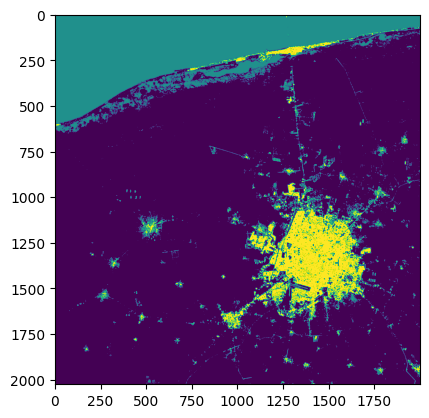

In [16]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
print(predicted_2015_class.reshape(x_features_2015_n.shape[0], 1))
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

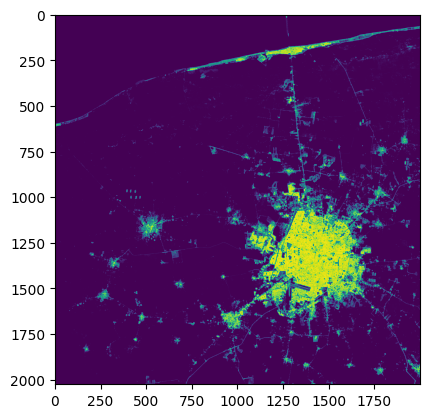

In [17]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [18]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

126625/126625 [==============================] - 191s 2ms/step
[[3.24325219e-11 9.99999940e-01 6.23491833e-38]
 [9.45057400e-13 9.99999940e-01 0.00000000e+00]
 [2.48924926e-12 9.99999940e-01 0.00000000e+00]
 ...
 [8.38949561e-01 4.01396333e-04 1.60648912e-01]
 [8.45765531e-01 4.39605588e-04 1.53794900e-01]
 [8.85374427e-01 4.28122527e-04 1.14197545e-01]]


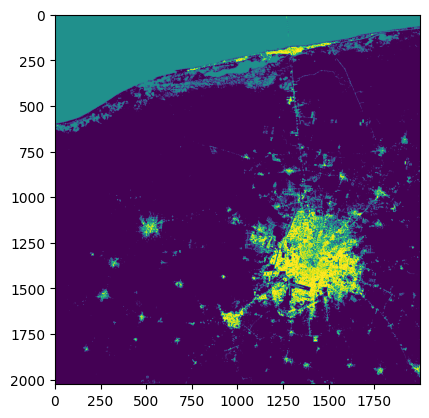

In [19]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

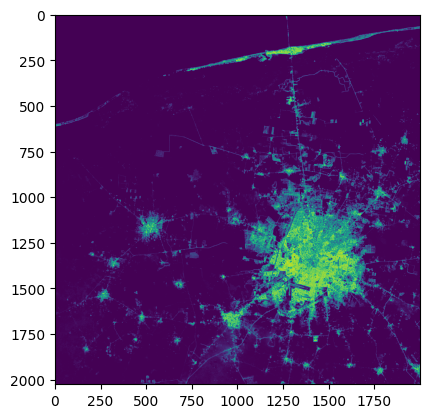

In [20]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [21]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

126625/126625 [==============================] - 196s 2ms/step
[[3.8169473e-04 9.9961835e-01 2.4584562e-12]
 [4.3479190e-04 9.9956518e-01 4.1968542e-12]
 [1.0938532e-04 9.9989051e-01 4.3012181e-14]
 ...
 [8.9938974e-01 1.2720113e-03 9.9338181e-02]
 [8.7561226e-01 8.3367125e-04 1.2355405e-01]
 [9.0566570e-01 9.1179577e-04 9.3422525e-02]]


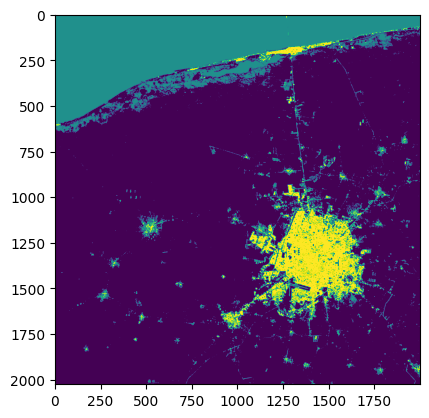

In [22]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

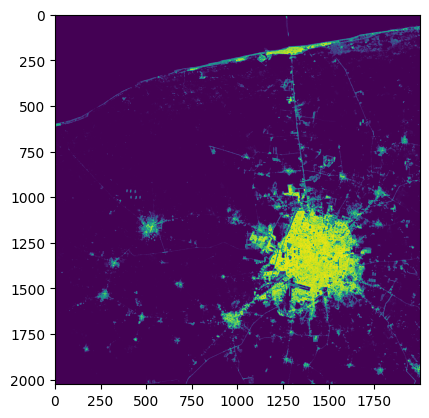

In [23]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [24]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/MID_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/MID_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/MID_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/MID_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/MID_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/MID_2020_prediction_urbano_float.npy', prediction_2020_urbano)

In [27]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2015_class.reshape(x_features_2015_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

# Define the parameters of the model
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model1.fit(x_features_2011_n, y_target_2011_n, epochs=3)

(4052000, 1, 6) (4052000, 1)
Epoch 1/3
126625/126625 [==============================] - 300s 2ms/step - loss: 0.0808 - accuracy: 0.9731
Epoch 2/3
126625/126625 [==============================] - 288s 2ms/step - loss: 0.0770 - accuracy: 0.9742
Epoch 3/3
126625/126625 [==============================] - 285s 2ms/step - loss: 0.0764 - accuracy: 0.9744


In [29]:
model1.save('/content/drive/MyDrive/Colab Data/MID_2011_model_ANN_2hl_3class.tensorflow')

In [30]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model.predict(x_features_2010_n)
print(predicted_2010)

126625/126625 [==============================] - 191s 2ms/step
[[8.1213858e-07 9.9999911e-01 1.4411663e-19]
 [7.4330910e-07 9.9999923e-01 5.1943333e-20]
 [2.4655861e-07 9.9999970e-01 6.2469191e-22]
 ...
 [9.8238802e-01 1.3052138e-04 1.7481355e-02]
 [9.7153383e-01 9.4778727e-05 2.8371422e-02]
 [9.9344778e-01 5.1528379e-05 6.5007159e-03]]


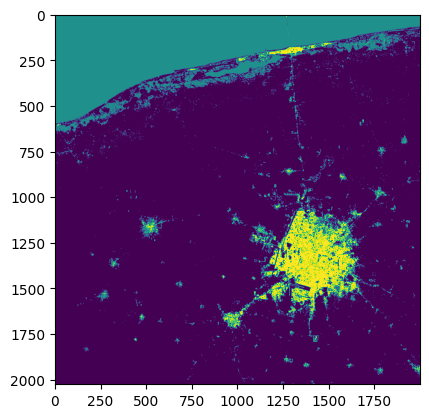

In [31]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

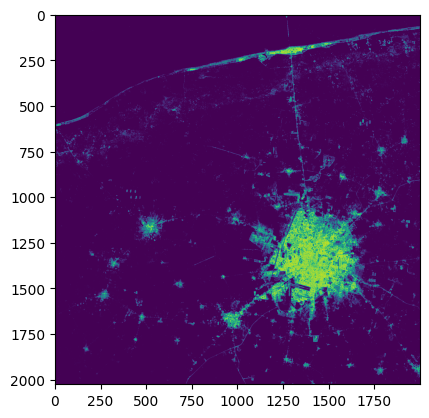

In [32]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

In [33]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model.predict(x_features_2000_n)
print(predicted_2000)

126625/126625 [==============================] - 188s 1ms/step
[[2.1646040e-08 9.9999994e-01 1.0049427e-26]
 [2.1646040e-08 9.9999994e-01 1.0049427e-26]
 [2.0667866e-07 9.9999970e-01 1.3008366e-23]
 ...
 [8.1477273e-01 2.9541745e-05 1.8519774e-01]
 [8.6669225e-01 1.0396835e-04 1.3320380e-01]
 [7.6052320e-01 2.4301208e-04 2.3923382e-01]]


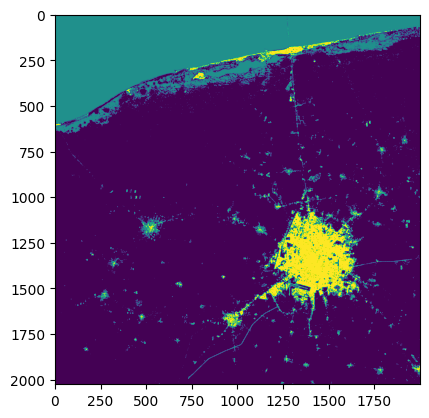

In [34]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2000_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

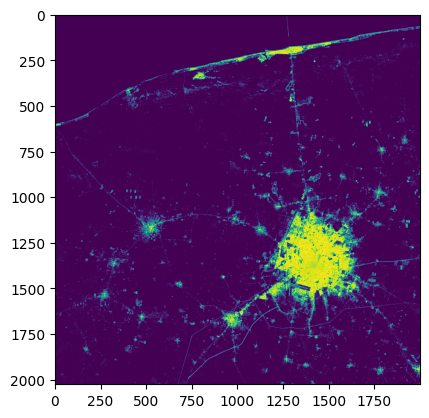

In [35]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [36]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/MID_2010_prediction_class.npy', predicted_2010_class_re)
np.save('/content/drive/MyDrive/Colab Data/MID_2000_prediction_class.npy', predicted_2000_class_re)
np.save('/content/drive/MyDrive/Colab Data/MID_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/MID_2000_prediction_urbano_float.npy', prediction_2000_urbano)